# LSTM Model for AWS Spot Price Prediction



<h3>Step #0. Import Library</h3>

In [1]:
# Import modules and packages
import gc
import os
import sys
import time
import numpy as np
import pandas as pd
import holidays
from functools import reduce
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Seed value (can actually be different for each attribution step)
seed_value= 0
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
%matplotlib inline

<h3>Step #1. Read data</h3>

In [2]:
# Importing Training Set
train = pd.read_csv('../input/preprocessed-all-region-us-east-us-west/train_test_train.csv')

import datetime as dt
train['Timestamp'] = pd.to_datetime(train['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
train['Date']= pd.to_datetime(train['Timestamp']).apply(lambda x: x.date())
train["Date"] = pd.to_datetime(train["Date"], format = '%Y-%m-%d')
train.head()

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-02-16 00:00:00+00:00,684.0,0.0671,2021-02-16
1,0,0,2021-02-16 01:00:00+00:00,720.0,0.0671,2021-02-16
2,0,0,2021-02-16 02:00:00+00:00,756.0,0.0671,2021-02-16
3,0,0,2021-02-16 03:00:00+00:00,792.0,0.0671,2021-02-16
4,0,0,2021-02-16 04:00:00+00:00,828.0,0.0671,2021-02-16


In [3]:
test = pd.read_csv('../input/flant-processed-data/train_test_test.csv')
test['Timestamp'] = pd.to_datetime(test['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
test['Date']= pd.to_datetime(test['Timestamp']).apply(lambda x: x.date())
test["Date"] = pd.to_datetime(test["Date"], format = '%Y-%m-%d')

<h3>Step #2. Add New Features</h3>

In [4]:
def feat_eng(df):
    
    df['Date'] = df['Timestamp'].dt.date
    df['Date'] = pd.to_datetime(df['Date'])

    #df['Year'] = df['Timestamp'].dt.year
    #df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    #df['Day_name'] = df['Timestamp'].dt.day_name()
    df['Hour'] = df['Timestamp'].dt.hour

    # daypart function
    def daypart(hour):
        if hour in [2,3,4,5]:
            return "Dawn"
        elif hour in [6,7,8,9]:
            return "Morning"
        elif hour in [10,11,12,13]:
            return "Noon"
        elif hour in [14,15,16,17]:
            return "Afternoon"
        elif hour in [18,19,20,21]:
            return "Evening"
        else: return "Midnight"
    
    #df['Day_parts'] = raw_dayparts = df.Timestamp.dt.hour.apply(daypart)


   # df['Weekday'] = df['Timestamp'].dt.weekday
    df['Weekend_YorN'] = ((df['Timestamp'].dt.dayofweek) // 5 == 1).astype(float)
    df['DayofYear'] = df['Timestamp'].dt.dayofyear


    us_holidays = holidays.UnitedStates() 
    hd = []

    # Print all the holidays in UnitedKingdom in year 2018
    for ptr in holidays.US(years = 2021).items():
        #print(ptr)
        hd.append(ptr[0])

    def extractServiceName(x):
        if x in hd:
            return 1
        else:
            return 0

    #df['Holiday_YorN'] = df['Date'].apply(lambda x : extractServiceName(x))

   

    df.drop('Timestamp', axis = 1, inplace = True)

    df = df.reset_index(drop = True)

    print (df.shape)
    
    return df

<h4>Appying Features Funtion to train/test data</h4>

In [5]:
train= feat_eng(train)
train

(5833407, 9)


,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date,Day,Hour,Weekend_YorN,DayofYear
0,0,0,684.0,0.0671,2021-02-16,16,0,0.0,47
1,0,0,720.0,0.0671,2021-02-16,16,1,0.0,47
2,0,0,756.0,0.0671,2021-02-16,16,2,0.0,47
3,0,0,792.0,0.0671,2021-02-16,16,3,0.0,47
4,0,0,828.0,0.0671,2021-02-16,16,4,0.0,47
...,...,...,...,...,...,...,...,...,...
5833402,14,381,46296.0,0.1002,2021-04-09,9,19,0.0,99
5833403,14,381,46332.0,0.1002,2021-04-09,9,20,0.0,99
5833404,14,381,46368.0,0.1002,2021-04-09,9,21,0.0,99
5833405,14,381,46404.0,0.1002,2021-04-09,9,22,0.0,99


In [6]:
test= feat_eng(test)
test

(304915, 9)


,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date,Day,Hour,Weekend_YorN,DayofYear
0,0,0,46476.0,0.0671,2021-04-10,10,0,1.0,100
1,0,0,46512.0,0.0671,2021-04-10,10,1,1.0,100
2,0,0,46548.0,0.0671,2021-04-10,10,2,1.0,100
3,0,0,46584.0,0.0671,2021-04-10,10,3,1.0,100
4,0,0,46620.0,0.0671,2021-04-10,10,4,1.0,100
...,...,...,...,...,...,...,...,...,...
304910,5,388,52272.0,0.1116,2021-04-16,16,17,0.0,106
304911,5,388,52308.0,0.1116,2021-04-16,16,18,0.0,106
304912,5,388,52344.0,0.1116,2021-04-16,16,19,0.0,106
304913,5,388,52380.0,0.1116,2021-04-16,16,20,0.0,106


In [7]:
fsub=test.copy()

In [8]:
#https://www.kaggle.com/wuyueliuye/lstm-for-aws-with-new-feature-copied-from-sumaia
train['4MA'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=4).mean())
train['4SD'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=4).std())
train['24MA'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=24).mean())
train['24SD'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=24).std())
train['upperband'] = train['24MA'] + 2*train['24SD']
train['lowerband'] = train['24MA'] - 2*train['24SD']

train['Diff'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.diff())
train['Up'] = train['Diff']
train.loc[(train['Up']<0), 'Up'] = 0

train['Down'] = train['Diff']
train.loc[(train['Down']>0), 'Down'] = 0 
train['Down'] = abs(train['Down'])

train['avg_4up'] = train.groupby(['AvailabilityZone','InstanceType'])['Up'].transform(lambda x: x.rolling(window=4).mean())
train['avg_4down'] = train.groupby(['AvailabilityZone','InstanceType'])['Down'].transform(lambda x: x.rolling(window=4).mean())

train['avg_24up'] = train.groupby(['AvailabilityZone','InstanceType'])['Up'].transform(lambda x: x.rolling(window=24).mean())
train['avg_24down'] = train.groupby(['AvailabilityZone','InstanceType'])['Down'].transform(lambda x: x.rolling(window=24).mean())

#train['RS_4'] = train['avg_4up'] / train['avg_4down']
#train['RS_24'] = train['avg_24up'] / train['avg_24down']
#train['RSI_4'] = 100 - (100/(1+train['RS_4'])) # relative strength index by every 4 hrs
#train['RSI_24'] = 100 - (100/(1+train['RS_24'])) # relative strngth index by day
#train['RSI_ratio'] = train['RSI_4']/train['RSI_24']

train['4Ewm'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.ewm(span=4, adjust=False).mean())
train['24Ewm'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.ewm(span=24, adjust=False).mean())
train['MACD'] = train['24Ewm'] - train['4Ewm']

train['RC_4'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.pct_change(periods = 4)) 
train['RC_24'] = train.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.pct_change(periods = 24)) 
train['Actual'] =train['SpotPrice']
train= train.drop(['SpotPrice'], axis=1)
train['SpotPrice'] =train['Actual']
train= train.drop(['Actual'], axis=1)
train


,AvailabilityZone,InstanceType,Timedel,Date,Day,Hour,Weekend_YorN,DayofYear,4MA,4SD,...,avg_4up,avg_4down,avg_24up,avg_24down,4Ewm,24Ewm,MACD,RC_4,RC_24,SpotPrice
0,0,0,684.0,2021-02-16,16,0,0.0,47,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
1,0,0,720.0,2021-02-16,16,1,0.0,47,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
2,0,0,756.0,2021-02-16,16,2,0.0,47,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
3,0,0,792.0,2021-02-16,16,3,0.0,47,0.0671,0.0,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
4,0,0,828.0,2021-02-16,16,4,0.0,47,0.0671,0.0,...,0.0,0.0,NaN,NaN,0.0671,0.0671,0.0,0.0,NaN,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833402,14,381,46296.0,2021-04-09,9,19,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002
5833403,14,381,46332.0,2021-04-09,9,20,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002
5833404,14,381,46368.0,2021-04-09,9,21,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002
5833405,14,381,46404.0,2021-04-09,9,22,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002


In [9]:
# test set

test['4MA'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=4).mean())
test['4SD'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=4).std())
test['24MA'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=24).mean())
test['24SD'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.rolling(window=24).std())
test['upperband'] = test['24MA'] + 2*test['24SD']
test['lowerband'] = test['24MA'] - 2*test['24SD']

test['Diff'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.diff())
test['Up'] = test['Diff']
test.loc[(test['Up']<0), 'Up'] = 0

test['Down'] = test['Diff']
test.loc[(test['Down']>0), 'Down'] = 0 
test['Down'] = abs(test['Down'])

test['avg_4up'] = test.groupby(['AvailabilityZone','InstanceType'])['Up'].transform(lambda x: x.rolling(window=4).mean())
test['avg_4down'] = test.groupby(['AvailabilityZone','InstanceType'])['Down'].transform(lambda x: x.rolling(window=4).mean())

test['avg_24up'] = test.groupby(['AvailabilityZone','InstanceType'])['Up'].transform(lambda x: x.rolling(window=24).mean())
test['avg_24down'] = test.groupby(['AvailabilityZone','InstanceType'])['Down'].transform(lambda x: x.rolling(window=24).mean())

#test['RS_4'] = test['avg_4up'] / test['avg_4down']
#test['RS_24'] = test['avg_24up'] / test['avg_24down']
#test['RSI_4'] = 100 - (100/(1+test['RS_4'])) # relative strength index by every 4 hrs
#test['RSI_24'] = 100 - (100/(1+test['RS_24'])) # relative strngth index by day
#test['RSI_ratio'] = test['RSI_4']/test['RSI_24']

test['4Ewm'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.ewm(span=4, adjust=False).mean())
test['24Ewm'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.ewm(span=24, adjust=False).mean())
test['MACD'] = test['24Ewm'] - test['4Ewm']

test['RC_4'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.pct_change(periods = 4)) 
test['RC_24'] = test.groupby(['AvailabilityZone','InstanceType'])['SpotPrice'].transform(lambda x: x.pct_change(periods = 24)) 


test['Actual'] =test['SpotPrice']
test= test.drop(['SpotPrice'], axis=1)
test['SpotPrice'] =test['Actual']
test= test.drop(['Actual'], axis=1)
test

,AvailabilityZone,InstanceType,Timedel,Date,Day,Hour,Weekend_YorN,DayofYear,4MA,4SD,...,avg_4up,avg_4down,avg_24up,avg_24down,4Ewm,24Ewm,MACD,RC_4,RC_24,SpotPrice
0,0,0,46476.0,2021-04-10,10,0,1.0,100,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
1,0,0,46512.0,2021-04-10,10,1,1.0,100,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
2,0,0,46548.0,2021-04-10,10,2,1.0,100,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
3,0,0,46584.0,2021-04-10,10,3,1.0,100,0.0671,0.0,...,NaN,NaN,NaN,NaN,0.0671,0.0671,0.0,NaN,NaN,0.0671
4,0,0,46620.0,2021-04-10,10,4,1.0,100,0.0671,0.0,...,0.0,0.0,NaN,NaN,0.0671,0.0671,0.0,0.0,NaN,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304910,5,388,52272.0,2021-04-16,16,17,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304911,5,388,52308.0,2021-04-16,16,18,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304912,5,388,52344.0,2021-04-16,16,19,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304913,5,388,52380.0,2021-04-16,16,20,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116


<h3>Step #3. Data pre-processing</h3>

In [10]:
## Print the categorical columns
print([c for c in train.columns if (1<train[c].nunique()) & (train[c].dtype != np.number)& (train[c].dtype != int) ])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  


['Date']


In [11]:
#cats=['Date', 'Day_name', 'Day_parts']
cats=['Date']


In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelEncoder, OrdinalEncoder
for col in cats:
    print(col)
    train_only = list(set(train[col].unique()) - set(test[col].unique()))
    test_only = list(set(test[col].unique()) - set(train[col].unique()))
    both = list(set(test[col].unique()).union(set(train[col].unique())))
    print(len(both), len(train_only), len(test_only))
    train.loc[train[col].isin(train_only), col] = np.nan
    test.loc[test[col].isin(test_only), col] = np.nan
    try:
        lbl = OrdinalEncoder(dtype='int')
        train[col] = lbl.fit_transform(train[col].astype('str').values.reshape(-1,1))
        train[col] = train[col].astype('category')
        test[col] = lbl.transform(test[col].astype('str').values.reshape(-1,1))
        test[col] = test[col].astype('category')
    except:
        try:
            lbl = LabelEncoder()
            fit_by = pd.Series([i for i in X[col].unique() if type(i) == str])
            lbl.fit(fit_by)
            train[col] = train[col].apply(lambda x: lbl.transform([x])[0] if type(x) == str else x)
            test[col] = test[col].apply(lambda x: lbl.transform([x])[0] if type(x) == str else x)
        except:
            drop_columns.append(col)

Date
60 53 7


In [13]:
train = train.replace([np.inf, -np.inf], np.nan)
train =train.fillna(0)
train

,AvailabilityZone,InstanceType,Timedel,Date,Day,Hour,Weekend_YorN,DayofYear,4MA,4SD,...,avg_4up,avg_4down,avg_24up,avg_24down,4Ewm,24Ewm,MACD,RC_4,RC_24,SpotPrice
0,0,0,684.0,0,16,0,0.0,47,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
1,0,0,720.0,0,16,1,0.0,47,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
2,0,0,756.0,0,16,2,0.0,47,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
3,0,0,792.0,0,16,3,0.0,47,0.0671,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
4,0,0,828.0,0,16,4,0.0,47,0.0671,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833402,14,381,46296.0,0,9,19,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002
5833403,14,381,46332.0,0,9,20,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002
5833404,14,381,46368.0,0,9,21,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002
5833405,14,381,46404.0,0,9,22,0.0,99,0.1002,0.0,...,0.0,0.0,0.0,0.0,0.1002,0.1002,0.0,0.0,0.0,0.1002


In [14]:
test = test.replace([np.inf, -np.inf], np.nan)
test= test.fillna(0)
test

,AvailabilityZone,InstanceType,Timedel,Date,Day,Hour,Weekend_YorN,DayofYear,4MA,4SD,...,avg_4up,avg_4down,avg_24up,avg_24down,4Ewm,24Ewm,MACD,RC_4,RC_24,SpotPrice
0,0,0,46476.0,0,10,0,1.0,100,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
1,0,0,46512.0,0,10,1,1.0,100,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
2,0,0,46548.0,0,10,2,1.0,100,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
3,0,0,46584.0,0,10,3,1.0,100,0.0671,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
4,0,0,46620.0,0,10,4,1.0,100,0.0671,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304910,5,388,52272.0,0,16,17,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304911,5,388,52308.0,0,16,18,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304912,5,388,52344.0,0,16,19,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304913,5,388,52380.0,0,16,20,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116


In [15]:
#https://datascience.stackexchange.com/questions/81617/how-to-combine-and-separate-test-and-train-data-for-data-cleaning
#dataset_train = pd.concat([dataset_train.assign(ind="test"), dataset_test.assign(ind="train")])
dataset_train = pd.concat([train, test])

#test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")] #Then later you can split them again:
dataset_train



,AvailabilityZone,InstanceType,Timedel,Date,Day,Hour,Weekend_YorN,DayofYear,4MA,4SD,...,avg_4up,avg_4down,avg_24up,avg_24down,4Ewm,24Ewm,MACD,RC_4,RC_24,SpotPrice
0,0,0,684.0,0,16,0,0.0,47,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
1,0,0,720.0,0,16,1,0.0,47,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
2,0,0,756.0,0,16,2,0.0,47,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
3,0,0,792.0,0,16,3,0.0,47,0.0671,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
4,0,0,828.0,0,16,4,0.0,47,0.0671,0.0,...,0.0,0.0,0.0,0.0,0.0671,0.0671,0.0,0.0,0.0,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304910,5,388,52272.0,0,16,17,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304911,5,388,52308.0,0,16,18,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304912,5,388,52344.0,0,16,19,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116
304913,5,388,52380.0,0,16,20,0.0,106,0.1116,0.0,...,0.0,0.0,0.0,0.0,0.1116,0.1116,0.0,0.0,0.0,0.1116


In [16]:
# Select features (columns) to be involved intro training and predictions
#cols = ['AvailabilityZone', 'InstanceType', 'Timedel', 'Day', 'Hour', 'Weekend_YorN', 'DayofYear', 'SpotPrice']
cols = ['InstanceType','AvailabilityZone','Date','Day','Hour' ,'Timedel', 'Weekend_YorN', 'DayofYear', '4MA', '4SD', '24MA', '24SD', 'upperband', 'lowerband', 'RC_24','SpotPrice']
#cols = ['InstanceType', 'AvailabilityZone', 'Date', 'Day', 'Hour', 'Timedel', 'Weekend_YorN', 'DayofYear', '4MA', '4SD', '24MA', '24SD', 'upperband', 'lowerband', 'RC_24', 'SpotPrice']
# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])


print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (6138322, 27)
All timestamps == 6138322
Featured selected: ['InstanceType', 'AvailabilityZone', 'Date', 'Day', 'Hour', 'Timedel', 'Weekend_YorN', 'DayofYear', '4MA', '4SD', '24MA', '24SD', 'upperband', 'lowerband', 'RC_24', 'SpotPrice']


<h4>Train data</h4>

In [17]:
dataset_train = dataset_train[cols].astype(str)
"""for i in cols:
    for j in range(0, len(dataset_train)):      

        dataset_train[i][j] = dataset_train[i][j].replace(',', '')"""

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()#.values()#as_matrix() https://stackoverflow.com/questions/61102281/dataframe-object-has-no-attribute-as-matrix

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (6138322, 16).


array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        6.710e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        6.710e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        6.710e-02],
       ...,
       [3.880e+02, 5.000e+00, 0.000e+00, ..., 1.116e-01, 0.000e+00,
        1.116e-01],
       [3.880e+02, 5.000e+00, 0.000e+00, ..., 1.116e-01, 0.000e+00,
        1.116e-01],
       [3.880e+02, 5.000e+00, 0.000e+00, ..., 1.116e-01, 0.000e+00,
        1.116e-01]])

In [18]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# training_set_scaled = sc.fit_transform(training_set)
sc.fit(training_set)
training_set_scaled = sc.transform(training_set)

In [19]:
print(f'Train rows: {dataset_train.shape[0]}')
print(f'Train columns: {dataset_train.shape[1]}')

display(dataset_train.head().T)
display(dataset_train.describe())

Train rows: 6138322
Train columns: 16


,0,1,2,3,4
InstanceType,0.0000,0.0000,0.0000,0.0000,0.0000
AvailabilityZone,0.0000,0.0000,0.0000,0.0000,0.0000
Date,0.0000,0.0000,0.0000,0.0000,0.0000
Day,16.0000,16.0000,16.0000,16.0000,16.0000
Hour,0.0000,1.0000,2.0000,3.0000,4.0000
Timedel,684.0000,720.0000,756.0000,792.0000,828.0000
Weekend_YorN,0.0000,0.0000,0.0000,0.0000,0.0000
DayofYear,47.0000,47.0000,47.0000,47.0000,47.0000
4MA,0.0000,0.0000,0.0000,0.0671,0.0671
4SD,0.0000,0.0000,0.0000,0.0000,0.0000


,InstanceType,AvailabilityZone,Date,Day,Hour,Timedel,Weekend_YorN,DayofYear,4MA,4SD,24MA,24SD,upperband,lowerband,RC_24,SpotPrice
count,6.138322e+06,6.138322e+06,6138322.0,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06,6.138322e+06
mean,1.954448e+02,6.679801e+00,0.0,1.546861e+01,1.150201e+01,2.508022e+04,2.652394e-01,7.475711e+01,6.633317e-01,2.490640e-04,6.486964e-01,1.102777e-03,6.509019e-01,6.464908e-01,3.320166e-05,6.655268e-01
std,1.101613e+02,4.452615e+00,0.0,8.807999e+00,6.918899e+00,1.406147e+04,4.414606e-01,1.627334e+01,1.074362e+00,3.544921e-03,1.066719e+00,1.017098e-02,1.072838e+00,1.060954e+00,1.216063e-02,1.075484e+00
min,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,6.840000e+02,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.698962e-01,1.300000e-03
25%,1.030000e+02,2.000000e+00,0.0,7.000000e+00,6.000000e+00,1.292400e+04,0.000000e+00,6.100000e+01,6.800000e-02,0.000000e+00,6.460000e-02,0.000000e+00,6.460000e-02,6.460000e-02,0.000000e+00,6.800000e-02
50%,1.940000e+02,7.000000e+00,0.0,1.600000e+01,1.200000e+01,2.516400e+04,0.000000e+00,7.500000e+01,2.919500e-01,0.000000e+00,2.808000e-01,0.000000e+00,2.808000e-01,2.796134e-01,0.000000e+00,2.970000e-01
75%,2.920000e+02,1.100000e+01,0.0,2.300000e+01,1.700000e+01,3.708000e+04,1.000000e+00,8.900000e+01,9.122000e-01,0.000000e+00,8.924000e-01,1.267629e-04,8.933862e-01,8.919480e-01,0.000000e+00,9.122000e-01
max,3.880000e+02,1.400000e+01,0.0,3.100000e+01,2.300000e+01,5.248800e+04,1.000000e+00,1.060000e+02,2.252390e+01,8.140707e-01,2.182704e+01,1.028772e+00,2.313388e+01,2.101011e+01,1.673908e-01,2.252390e+01


<h4>Convert data to supervised form</h4>

In [20]:
#convert data to supervised form

def to_supervised(dataset_train,dropNa = True,lag = 2): ## specify the number of lag hours

    df = pd.DataFrame(dataset_train)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = dataset_train.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [21]:
timeSteps = 2

supervised = to_supervised(training_set_scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1.77417,-1.500198,0.0,0.060331,-1.662404,-1.734969,-0.600822,-1.705681,-0.617420,-0.070259,...,-1.705681,-0.617420,-0.070259,-0.608123,-0.108424,-0.60671,-0.609349,-0.00273,-0.556426,-1.77417
1,-1.77417,-1.500198,0.0,0.060331,-1.517872,-1.732409,-0.600822,-1.705681,-0.617420,-0.070259,...,-1.705681,-0.617420,-0.070259,-0.608123,-0.108424,-0.60671,-0.609349,-0.00273,-0.556426,-1.77417
2,-1.77417,-1.500198,0.0,0.060331,-1.373341,-1.729849,-0.600822,-1.705681,-0.617420,-0.070259,...,-1.705681,-0.554964,-0.070259,-0.608123,-0.108424,-0.60671,-0.609349,-0.00273,-0.556426,-1.77417
3,-1.77417,-1.500198,0.0,0.060331,-1.228809,-1.727289,-0.600822,-1.705681,-0.554964,-0.070259,...,-1.705681,-0.554964,-0.070259,-0.608123,-0.108424,-0.60671,-0.609349,-0.00273,-0.556426,-1.77417
4,-1.77417,-1.500198,0.0,0.060331,-1.084277,-1.724728,-0.600822,-1.705681,-0.554964,-0.070259,...,-1.705681,-0.554964,-0.070259,-0.608123,-0.108424,-0.60671,-0.609349,-0.00273,-0.556426,-1.77417


In [22]:
# spiltting the data
# training 365(number of days per year) *24

features =dataset_train.shape[1]
train_hours = len(train)


X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(5833407, 32) (304913, 32) (5833407,) (304913,)


In [23]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(5833407, 2, 16) (304913, 2, 16)


<h2>PART 2. Create a model. Training</h2>

<h3>Step #4. Building the LSTM based Neural Network</h3>

In [24]:
#define the model

model = Sequential()
model.add( LSTM( 50, activation='relu', input_shape = ( timeSteps,x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

<h3>Step #5. Start training</h3>

In [25]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, mode="auto", verbose=1)#https://keras.io/api/callbacks/early_stopping/
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,  mode="auto", min_delta=0.0001,verbose=1) #https://keras.io/api/callbacks/reduce_lr_on_plateau/
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(x_train, y_train, shuffle=True, epochs=200, callbacks=[es, rlr, mcp, tb],validation_data = (x_test,y_test), verbose=1, batch_size=256)

Epoch 1/200
22787/22787 [==============================] - 100s 4ms/step - loss: 0.0216 - val_loss: 0.0039

Epoch 00001: val_loss improved from inf to 0.00389, saving model to weights.h5
Epoch 2/200
22787/22787 [==============================] - 97s 4ms/step - loss: 0.0019 - val_loss: 0.0033

Epoch 00002: val_loss improved from 0.00389 to 0.00329, saving model to weights.h5
Epoch 3/200
22787/22787 [==============================] - 97s 4ms/step - loss: 0.0016 - val_loss: 0.0028

Epoch 00003: val_loss improved from 0.00329 to 0.00276, saving model to weights.h5
Epoch 4/200
22787/22787 [==============================] - 97s 4ms/step - loss: 0.0015 - val_loss: 0.0029

Epoch 00004: val_loss did not improve from 0.00276
Epoch 00004: early stopping
CPU times: user 11min 52s, sys: 1min 38s, total: 13min 31s
Wall time: 6min 31s


<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>


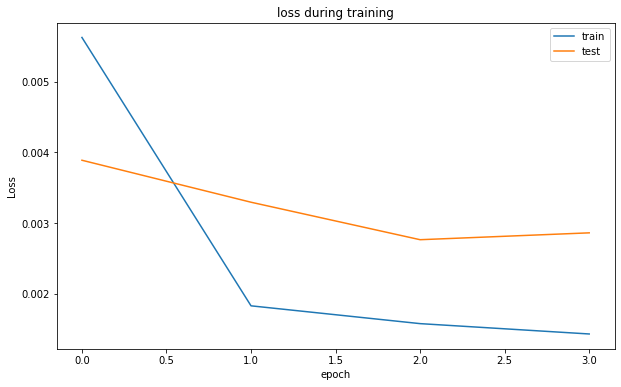

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("loss during training")
plt.show()

<h2>PART 3. Make future predictions</h2>

<h4>Test</h4>

In [27]:
#scale back the prediction to orginal scale
prediction= model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (prediction, x_test[:,-15:] ) , axis =1)
inv_new = sc.inverse_transform(inv_new)
final_prediction = inv_new[:,-1]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-15:] ) ,axis = 1)
inv_new = sc.inverse_transform(inv_new)
actual_prediction = inv_new[:,-1]


In [28]:
prediction

array([[-1.7759726],
       [-1.7759933],
       [-1.7755746],
       ...,
       [ 1.7537074],
       [ 1.7538202],
       [ 1.7539331]], dtype=float32)

In [29]:
y_test

array([[-1.77416975],
       [-1.77416975],
       [-1.77416975],
       ...,
       [ 1.74793936],
       [ 1.74793936],
       [ 1.74793936]])

In [30]:
final_prediction = inv_new[:,-1]

<h3>Step #6. Visualize the Predictions</h3>

<h4>Test</h4>

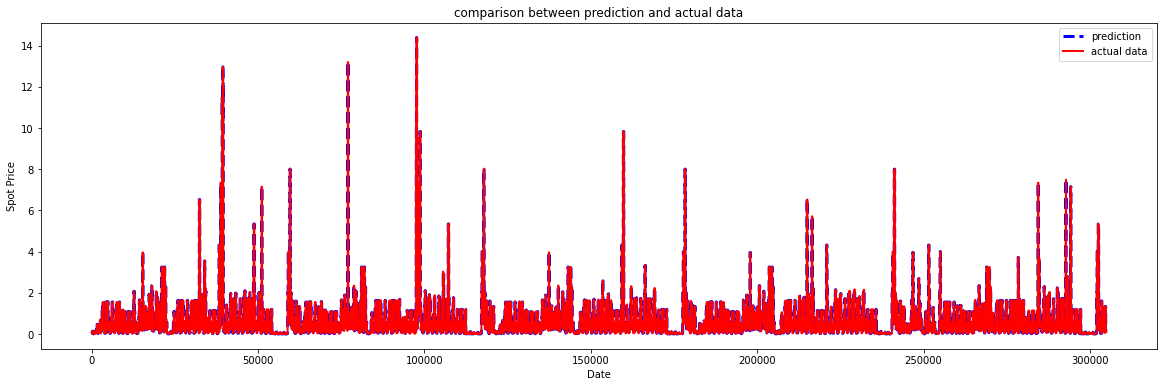

In [31]:
#plot the prediction with actual data
plt.figure(figsize=(20, 6))
plt.plot(final_prediction, linewidth =3,label = "prediction",c = "blue", linestyle = '--')
plt.plot(actual_prediction,linewidth = 2,label = "actual data",c="red")
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title("comparison between prediction and actual data")
plt.legend()

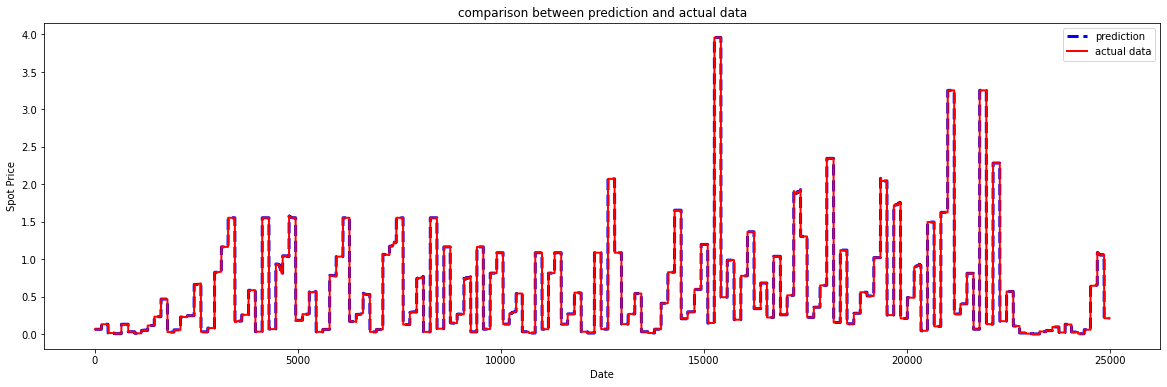

In [32]:
#plot the prediction with actual data
plt.figure(figsize=(20, 6))
plt.plot(final_prediction[:25000], linewidth =3,label = "prediction",c = "blue", linestyle = '--')
plt.plot(actual_prediction[:25000],linewidth = 2,label = "actual data",c="red")
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title("comparison between prediction and actual data")
plt.legend()

<h3>Step #7. Measurement</h3>

<h4>Test</h4>

In [33]:
# Before Scalling back
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
def evaluate_prediction(final_prediction, actual_prediction, model):
    errors = actual_prediction - final_prediction
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(errors/actual_prediction).mean() * 100
   # mape = np.abs(errors/actual_prediction)* 100

    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolut Percentage Error: {:.4f}'.format(mape))
    print('')
evaluate_prediction(prediction, y_test, 'LSTM')

Mean Absolute Error: 0.0029
Root Mean Square Error: 0.0150
Mean Absolut Percentage Error: 1.1766



In [34]:
col1 = pd.DataFrame(final_prediction, columns=['Prediction'])
col2 = pd.DataFrame(actual_prediction, columns=['SpotPrice'])

results = pd.concat([col1, col2], axis=1)
results.to_csv('results.csv', index=False)
results

,Prediction,SpotPrice
0,0.0671,0.0671
1,0.0671,0.0671
2,0.0671,0.0671
3,0.0671,0.0671
4,0.0671,0.0671
...,...,...
304908,0.1116,0.1116
304909,0.1116,0.1116
304910,0.1116,0.1116
304911,0.1116,0.1116


### Compariosn with the Test Set

In [35]:
a = final_prediction
a = a.tolist()
a.insert(0, np.NaN)
a.insert(0, np.NaN)
a[0:10]

[nan,
 nan,
 0.06710000000000005,
 0.06710000000000005,
 0.06710000000000005,
 0.06710000000000005,
 0.06710000000000005,
 0.06710000000000005,
 0.06710000000000005,
 0.06710000000000005]

In [36]:
test = test.copy()
test = test[['AvailabilityZone', 'InstanceType', 'Timedel', 'SpotPrice']]

In [37]:
test['Price Prediction'] = a
test = test[['AvailabilityZone', 'InstanceType', 'Timedel', 'SpotPrice', 'Price Prediction' ]]
test

,AvailabilityZone,InstanceType,Timedel,SpotPrice,Price Prediction
0,0,0,46476.0,0.0671,NaN
1,0,0,46512.0,0.0671,NaN
2,0,0,46548.0,0.0671,0.0671
3,0,0,46584.0,0.0671,0.0671
4,0,0,46620.0,0.0671,0.0671
...,...,...,...,...,...
304910,5,388,52272.0,0.1116,0.1116
304911,5,388,52308.0,0.1116,0.1116
304912,5,388,52344.0,0.1116,0.1116
304913,5,388,52380.0,0.1116,0.1116


In [38]:
prediction_df=test.copy()
prediction_df.to_csv('prediction.csv', index=False)
prediction_df.head()

,AvailabilityZone,InstanceType,Timedel,SpotPrice,Price Prediction
0,0,0,46476.0,0.0671,NaN
1,0,0,46512.0,0.0671,NaN
2,0,0,46548.0,0.0671,0.0671
3,0,0,46584.0,0.0671,0.0671
4,0,0,46620.0,0.0671,0.0671


In [39]:
# After Scalling back
# https://www.kaggle.com/sumaiaparveenshupti/flant-aws-lstm-final?scriptVersionId=64634178
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

def evaluate_prediction(final_prediction, actual_prediction, model):
    errors = actual_prediction - final_prediction
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(errors/actual_prediction).mean() * 100
    #r2 = r2_score(actual_prediction, final_prediction)

    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
    #print('R2 Score: {:.4f}'.format(r2))
    print('')
    
evaluate_prediction(test['Price Prediction'], test.SpotPrice, 'LSTM')

Mean Absolute Error: 0.0051
Root Mean Square Error: 0.1140
Mean Absolute Percentage Error: 2.6201

